In [1]:
import sys
import time


from pullnet import PullNet
from graftnet import GraftNet
from pullnet_data_loader import DataLoader
from fpnet_data_loader import FpNetDataLoader
from relreasoner_data_loader import RelReasonerDataLoader
from fpnet import FactsPullNet
from util import *
from multiprocessing.pool import Pool


import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
cfg = get_config('config/webqsp.yml')
facts = load_json('datasets/complexwebq/all_facts_all_new2.json')
word2id = load_dict(cfg['data_folder'] + cfg['word2id'])
relation2id = load_dict(cfg['data_folder'] + cfg['relation2id'])
entity2id = load_dict(cfg['data_folder'] + cfg['entity2id'])
features = load_json('datasets/complexwebq/features.json')
num_hop = cfg['num_hop']

In [3]:
facts2 = load_json('datasets/webqsp/facts.json')

In [4]:
def load_fact3(file):
    kb = dict()
    with open(file) as f:
        for line in f.readlines():
            line = line.strip()
            line = line.replace('www.freebase.com/', '')
            line = line.replace('/', '.')
            triple = line.split()
            triple = list(map(str.strip, triple))
            if len(triple) < 3:
                continue
            s, p, o = triple[:3]
            # s = s.replace('%', '')
            # o = o.replace('%', '')
            if s not in kb:
                kb[s] = dict()
            if p not in kb[s]:
                kb[s][p] = dict()
            if o not in kb[s][p]:
                kb[s][p][o] = 0
            if o not in kb:
                kb[o] = dict()
            if p not in kb[o]:
                kb[o][p] = dict()
            if s not in kb[o][p]:
                kb[o][p][s] = 1
    return kb
facts3 = load_fact3('datasets/webqsp/freebase-FB5M.txt')

In [6]:
len(facts), len(facts2), len(facts3)

(7624604, 7083673, 2249337)

In [7]:
merged = facts.copy()
for s in facts2:
    if s not in merged:
        merged[s] = dict()
    for p in facts2[s]:
        if p not in merged[s]:
            merged[s][p] = dict()
        for o in facts2[s][p]:
            if o not in merged[s][p]:
                merged[s][p][o] = facts2[s][p][o]
for s in facts3:
    if s not in merged:
        merged[s] = dict()
    for p in facts3[s]:
        if p not in merged[s]:
            merged[s][p] = dict()
        for o in facts3[s][p]:
            if o not in merged[s][p]:
                merged[s][p][o] = facts3[s][p][o]

In [8]:
len(facts), len(facts2), len(merged)

(7624604, 7083673, 13163105)

In [11]:
train_data = RelReasonerDataLoader(cfg['data_folder'] + cfg['train_data'], facts, features, num_hop,
                        word2id, relation2id, cfg['max_query_word'], cfg['use_inverse_relation'], 1, teacher_force=True)

valid_data = RelReasonerDataLoader(cfg['data_folder'] + cfg['dev_data'], facts, features, num_hop,
                        word2id, relation2id, cfg['max_query_word'], cfg['use_inverse_relation'], 1, teacher_force=False)

test_data = RelReasonerDataLoader(cfg['data_folder'] + cfg['test_data'], facts, features, num_hop,
                        word2id, relation2id, cfg['max_query_word'], cfg['use_inverse_relation'], 1, teacher_force=False)

100%|██████████| 2848/2848 [00:00<00:00, 601176.54it/s]
728it [00:00, 3631.93it/s]loading data from datasets/webqsp/train_new.json
building word index ...
max_local_path_rel: 647
preparing data ...
3454it [00:00, 3569.36it/s]
100%|██████████| 250/250 [00:00<00:00, 321649.08it/s]
304it [00:00, 3541.92it/s]
100%|██████████| 1639/1639 [00:00<00:00, 737920.16it/s]
0it [00:00, ?it/s]avg_total_words_recall 0.8946149392009262
avg_question_words_recall 0.9997828604516502
loading data from datasets/webqsp/dev_new.json
building word index ...
max_local_path_rel: 647
preparing data ...
avg_total_words_recall 0.8963815789473685
avg_question_words_recall 1.0
loading data from datasets/webqsp/test_new.json
building word index ...
max_local_path_rel: 647
preparing data ...
1984it [00:00, 3514.44it/s]avg_total_words_recall 0.900957661290323
avg_question_words_recall 1.0



In [64]:
wrong = 0
total = 0
for e in train_data.data + valid_data.data + test_data.data:
    if 'rel_chain_map' not in e:
        continue
    if '1' not in e['rel_chain_map']:
        continue
    for entity in e['rel_chain_map']['1']:
        gt_rel = e['rel_chain_map']['1'][entity]['ground_truth'][0][0]
        if entity not in facts or gt_rel not in facts[entity]:
            # print(entity)
            # print(gt_rel)
            # print(e['sparql'])
            # asdasd
            wrong += 1
        total += 1
print(wrong / total)

0.009608091024020228


In [62]:
from collections import defaultdict
wrong = 0
total = 0
avg_hit_at_one = 0
print_cnt = 0
remove_triples = set()
add_triples = set()
is_entity = lambda x: not x.startswith('?') 
for i, e in tqdm(enumerate(train_data.data + valid_data.data + test_data.data)):
    if 'rel_chain_map' not in e:
        continue
    rel_chain_map = e['rel_chain_map']
    last_hop_gt = {k: v['ground_truth'][0] for k, v in rel_chain_map[str(len(rel_chain_map))].items()}
    last_hop_pred_ans = dict()
    entity2prev = defaultdict(set)
    for k in last_hop_gt:
        flag = True
        if k not in merged:
            flag = False
        prev_entities = [k]
        for v in last_hop_gt[k]:
            if 'EOD' == v:
                continue
            next_entities = set()
            for prev_entity in prev_entities:
                if prev_entity in merged and v in merged[prev_entity]:
                    next_entities.update(list(merged[prev_entity][v].keys()))
                    for kk in list(merged[prev_entity][v].keys()):
                        entity2prev[kk].add((prev_entity, v))
            prev_entities = list(next_entities)
        last_hop_pred_ans[k] = prev_entities
    merged_answers = None
    for k, v in last_hop_pred_ans.items():
        if merged_answers is None:
            merged_answers = set(v)
        else:
            merged_answers &= set(v)
    # print([len(last_hop_pred_ans[k]) for k in last_hop_pred_ans])
    hit_at_one = list(merged_answers)[0] in e['answers'] if len(merged_answers) > 0 else 0
    # if hit_at_one == 0:
    #     answers = set(e['answers'])
    #     if len(answers & merged_answers) == len(answers) and answers != merged_answers:
    #         outliers = merged_answers - answers
    #         for outlier in outliers:
    #             for s, p in entity2prev[outlier]:
    #                 remove_triples.add((s, p, outlier))
    # _-------------------------------------
    # if hit_at_one == 0:
    #     if e['sparql'].count('FILTER') <= 2 and 'filter(' not in e['sparql'].lower() and 'ORDER BY' not in e['sparql'] and 'UNION' not in e['sparql']:
    #         sparql = e['sparql']
    #         sparql = sparql.replace('PREFIX ns:', '').replace('SELECT DISTINCT ?x', '').replace('WHERE {', '')
    #         sparql = [sss.strip().replace('ns:', '') for sss in sparql.split('\n') if not sss.strip().lower().startswith('filter') and not sss.strip().lower().startswith('select') and sss.strip() != '}']
    #         for lll in sparql:
    #             if not lll.strip():
    #                 continue
    #             lll = list(map(str.strip, lll.split()))[:3]
    #             if len(lll) != 3:
    #                 continue
    #             topic = None
    #             if is_entity(lll[0]) and lll[2] == '?x':
    #                 topic = lll[0]
    #             elif is_entity(lll[2]) and lll[0] == '?x':
    #                 topic = lll[2]
    #             for answer in e['answers']:
    #                 if topic is not None and (topic not in merged or lll[1] not in merged[topic] or answer not in merged[topic][lll[1]]):
    #                     add_triples.add((topic, lll[1], answer))
    # _-------------------------------------
            # print()
            # print(e['answers'])
            # print(merged_answers)
            # print_cnt += 1

    if hit_at_one == 0 and print_cnt < 20:
        print(e['sparql'])
        print(sorted(e['answers'])[:10])
        print(sorted(list(merged_answers))[:10])
        print()
        print_cnt += 1
    avg_hit_at_one += int(hit_at_one)
    total += 1
print(avg_hit_at_one / total)







0it [00:00, ?it/s]





73it [00:00, 354.42it/s]PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ns:m.01g65g)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
ns:m.01g65g ns:film.person_or_entity_appearing_in_film.films ?y .
?y ns:film.personal_film_appearance.film ?x .
}

['m.0gyqzbv']
[]

PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ns:m.05yqrl)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
ns:m.05yqrl ns:people.person.places_lived ?y .
?y ns:people.place_lived.location ?x .
FILTER(NOT EXISTS {?y ns:people.place_lived.end_date ?sk0} || 
EXISTS {?y ns:people.place_lived.end_date ?sk1 . 
FILTER(xsd:datetime(?sk1) >= "2015-08-10"^^xsd:dateTime) })
FILTER(NOT EXISTS {?y ns:people.place_lived.start_date ?sk2} || 
EXISTS {?y ns:people.place_lived.start_date ?sk3 . 
FILTER(xsd:datetime(?sk3) <= "2015-08-10"^^xsd:dateTime) })
}

['m.0r_g0']
[]

PREFIX ns: <http://rdf.f

In [34]:
for e in train_data.data:
    if 'ORDER BY' in e['sparql']:
        print(e['rel_chain_map']['2']['m.083p7'])
        break

{'ground_truth': [['government.government_position_held.office_holder', 'government.government_office_or_title.office_holders']], 'cands': [['government.government_position_held.office_holder', 'government.government_position_held.district_represented'], ['government.government_position_held.office_holder', 'government.political_district.representatives'], ['government.government_position_held.office_holder', 'government.government_office_or_title.office_holders'], ['government.government_position_held.office_holder', 'government.government_position_held.basic_title'], ['government.government_position_held.office_holder', 'government.governmental_jurisdiction.governing_officials'], ['government.government_position_held.office_holder', 'government.government_position_held.office_position_or_title'], ['government.government_position_held.office_holder', 'government.government_position_held.from'], ['government.government_position_held.office_holder', 'government.politician.government_pos

In [61]:
for s, p, o in add_triples:
    if s not in merged:
        merged[s] = dict()
    if p not in merged[s]:
        merged[s][p] = dict()
    if o not in merged[s][p]:
        merged[s][p][o] = 0
    if o not in merged:
        merged[o] = dict()
    if p not in merged[o]:
        merged[o][p] = dict()
    if s not in merged[o][p]:
        merged[o][p][s] = 1

In [63]:
save_json(merged, 'datasets/webqsp/merged_facts.json')

In [100]:
list(remove_triples)[0]

('m.09c7w0', 'location.location.contains', 'm.04c2z61')

In [66]:
all_relations = set()
for e in train_data.data + valid_data.data + test_data.data:
    rel_chain_map = e['rel_chain_map']
    last_hop_gt = {k: v['ground_truth'][0] for k, v in rel_chain_map[str(len(rel_chain_map))].items()}
    for rels in last_hop_gt.values():
        all_relations.update(rels)
all_relations.add('EOD')
all_relations.add('SOS')
with open('datasets/webqsp/relations_v2.txt', 'w') as f:
    for e in sorted(all_relations):
        f.writelines(e + '\n')
print(len(all_relations))

613


In [124]:
test_facts = dict()
test_facts['a'] = dict()
test_facts['b'] = dict()
test_facts['c'] = dict()
test_facts['a']['d'] = dict()
test_facts['a']['e'] = dict()
test_facts['a']['d']['j'] = 1
test_facts['a']['d']['k'] = 1
test_facts['b']['f'] = dict()
test_facts['b']['g'] = dict()
test_facts['b']['f']['l'] = 1
test_facts['b']['g']['k'] = 0
test_facts['c']['h'] = dict()
test_facts['c']['h']['i'] = 1

for s in list(test_facts):
    for p in list(test_facts[s]):
        for o in list(test_facts[s][p]):
            if (s, p, o) == ('b', 'g', 'k'):
                del test_facts[s][p][o]
print(test_facts)


{'a': {'d': {'j': 1, 'k': 1}, 'e': {}}, 'b': {'f': {'l': 1}, 'g': {}}, 'c': {'h': {'i': 1}}}


In [17]:
for s in tqdm(list(merged)):
    for p in list(merged[s]):
        for o in list(merged[s][p]):
            if (s, p, o) in remove_triples or (o, p, s) in remove_triples:
                if s in merged and p in merged[s] and o in merged[s][p]:
                    del merged[s][p][o]
                if o in merged and p in merged[o] and s in merged[o][p]:
                    del merged[o][p][s]

05 [00:09<01:38, 124662.40it/s]
100%|██████████| 13163105/13163105 [00:41<00:00, 318254.49it/s]


In [114]:
from __future__ import print_function  # for Python2
import sys

local_vars = list(locals().items())
rank = dict()
for var, obj in local_vars:
    rank[var] = sys.getsizeof(obj)
for l in sorted(rank.items(), key=lambda x: x[1], reverse=True):
    print(l)

('merged', 671088752)
('features', 335544424)
('entity2id', 20971624)
('remove_triples', 8388840)
('word2id', 589936)
('entity2prev', 147576)
('relation2id', 18536)
('outliers', 16616)
('rank', 9328)
('cfg', 2288)
('_62', 2288)
('local_vars', 2256)
('_i97', 2110)
('_i96', 2104)
('_i95', 2037)
('_i94', 2017)
('tqdm', 2008)
('_i93', 1784)
('_i92', 1779)
('_i91', 1530)
('_i90', 1514)
('_i89', 1508)
('_i88', 1498)
('_i85', 1468)
('_i77', 1440)
('_i76', 1317)
('_i74', 1310)
('_i73', 1288)
('_i70', 1287)
('_i71', 1286)
('_i72', 1283)
('_i75', 1283)
('_i69', 1263)
('_i68', 1237)
('_i67', 1232)
('_i66', 1184)
('_ih', 1080)
('In', 1080)
('PullNet', 1064)
('GraftNet', 1064)
('DataLoader', 1064)
('FpNetDataLoader', 1064)
('FactsPullNet', 1064)
('Variable', 1064)
('LeftMMFixed', 1064)
('Pool', 1064)
('_i63', 1016)
('_i38', 977)
('_i61', 976)
('_i65', 960)
('_i64', 954)
('_i59', 924)
('_i37', 916)
('_i36', 915)
('_i56', 901)
('_i57', 901)
('_i58', 901)
('RelReasonerDataLoader', 896)
('_i55', 893)
(

In [116]:
merged2 = None

In [86]:
merged['m.07_dn']['organization.organization.spun_off_from']

{'m.02_8385': 0, 'm.0dk11j': 1}

In [87]:
merged['m.02_8385']['organization.organization_spin_off.parent_company']

{'m.0dk11j': 0}

In [ ]:
merged['m.0gyqzbs']['']

In [3]:
test_data = RelReasonerDataLoader(cfg['data_folder'] + cfg['test_data'], facts, num_hop,
                        word2id, relation2id, cfg['max_query_word'], cfg['use_inverse_relation'], 1)

loading data from /home/hxssgaa/Developer/GraftNet/datasets/metaqa/3hop/test_v4.json


100%|██████████| 14274/14274 [00:00<00:00, 1221253.19it/s]
708it [00:00, 7075.27it/s]

div 1 14274
max_rel_paths 88
building word index ...
preparing data ...
preparing data ...


14274it [00:01, 7149.07it/s]


In [28]:
with open('/home/hxssgaa/Downloads/qa_train_qtype.txt') as f:
    train_qtypes = f.readlines()

In [33]:
count = 0
for idx, e in enumerate(train_data.data):
    for path in e['rel_path']:
        for p in path:
            if p in ('has_imdb_votes', 'has_imdb_rating'):
                if count > 10:
                    print(e['question'])
                    print(e['rel_path'])
                    print(e['entities'])
                    print(idx)
                    print(train_qtypes[idx])
                    asd
                count += 1

when did the films written by Spice World writers release ?
[['release_year', 'release_year', 'release_year'], ['has_imdb_votes', 'has_imdb_votes', 'release_year'], ['has_tags', 'has_tags', 'release_year'], ['has_genre', 'has_genre', 'release_year'], ['written_by', 'written_by', 'release_year']]
[{'text': 'Spice World', 'kb_id': 'Spice World'}]
330
movie_to_writer_to_movie_to_year



NameError: name 'asd' is not defined

In [6]:
train_data.data[0]['entities'][0]['text']

'Dil Chahta Hai'

In [24]:
train_data.data[11]['rel_path_new']

[['has_genre', 'has_genre', 'directed_by'], ['directed_by']]

In [12]:
facts['Dil Chahta Hai']

{'Farhan Akhtar': ['directed_by', 0],
 'Aamir Khan': ['starred_actors', 0],
 'Preity Zinta': ['starred_actors', 0],
 'Saif Ali Khan': ['starred_actors', 0],
 'Akshaye Khanna': ['starred_actors', 0],
 '2001': ['release_year', 0],
 'English': ['in_language', 0],
 'Hindi': ['in_language', 0],
 'Drama': ['has_genre', 0],
 'Comedy': ['has_genre', 0],
 'comedy': ['has_tags', 0]}

In [9]:
train_data.data[0]['path']

{'0': ['Dil Chahta Hai'],
 '1': ['Aamir Khan', 'Saif Ali Khan', '2001', 'Farhan Akhtar', 'Preity Zinta'],
 '2': ['Ishq',
  'Koi... Mil Gaya',
  'Don',
  'Ghajini',
  'Luck by Chance',
  'Veer-Zaara',
  'Karthik Calling Karthik',
  'Dil Se..',
  'PK',
  'Agent Vinod',
  'Salaam Namaste'],
 '3': ['2003',
  '2008',
  '2010',
  '2006',
  '2012',
  '1998',
  '2004',
  '2009',
  '2014',
  '2005',
  '1997']}

In [30]:
def find_rels(entity, num_hop, tmp_path, visited):
    if entity in visited:
        return []
    if num_hop == 0:
        return {tuple(tmp_path)}
    visited.add(entity)
    res = set()
    entity = entity.replace('%', '')
    for k2 in facts[entity]:
        v = find_rels(k2, num_hop - 1, tmp_path + [facts[entity][k2][0]], visited)
        res.update(v)
    return res


def find_rels_ans(entity, answers, num_hop, tmp_path, visited):
    if entity in visited:
        return []
    if num_hop == 0 or entity in answers:
        if entity in answers:
            return {tuple(tmp_path)}
        return set()
    visited.add(entity)
    res = set()
    entity = entity.replace('%', '')
    for k2 in facts[entity]:
        v = find_rels_ans(k2, answers, num_hop - 1, tmp_path + [facts[entity][k2][0]], visited)
        res.update(v)
    return res

In [31]:
def find_rels_for_questions(questions):
    res = []
    for e in questions:
        visited = set()
        entity = e['entities'][0]['text']
        v = find_rels(entity, 3, [], visited)
        e['rel_cands'] = list(v)
        res.append(e)
    return res


def find_rels_ans_for_questions(questions):
    res = []
    for e in questions:
        visited = set()
        answers = set(map(lambda x: x['text'], e['answers']))
        entity = e['entities'][0]['text']
        v = find_rels_ans(entity, answers, 3, [], visited)
        e['rel_path_new'] = list(v)
        res.append(e)
    return res

In [39]:
PARALLEL_PROCESSOR = 24
questions = test_data.data
with Pool(processes=PARALLEL_PROCESSOR) as pool:
    res = pool.map(find_rels_ans_for_questions, [questions[(i * len(questions) // PARALLEL_PROCESSOR): 
                                              ((i + 1) * len(questions) // PARALLEL_PROCESSOR)] for i in range(PARALLEL_PROCESSOR)])

res = [e for l in res for e in l]
save_json(res, '/home/hxssgaa/Developer/GraftNet/datasets/metaqa/3hop/test_v4.json')

In [41]:
lens = []
wrong = 0
for e in res:
    if len(e['rel_path_new']) == 0:
        wrong += 1
print(wrong)

0


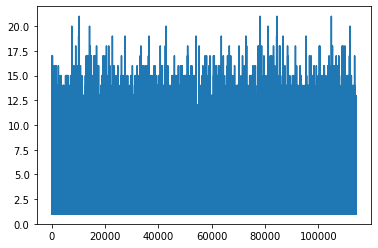

In [36]:
import matplotlib.pyplot as plt

plt.plot(lens)
plt.show()

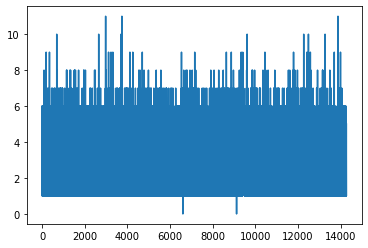

In [7]:
import matplotlib.pyplot as plt
path_lens = []
for e in valid_data.data:
    path_lens.append(len(e['rel_path']))
plt.plot(path_lens)
plt.show()

In [3]:
def inference_relreasoner(my_model, valid_data, entity2id, cfg, log_info=False):
    # Evaluation
    my_model.eval()
    my_model.teacher_force = False
    eval_hit_at_one, eval_loss, eval_recall, eval_max_acc = [], [], [], []
    id2entity = {idx: entity for entity, idx in entity2id.items()}
    valid_data.reset_batches(is_sequential = True)
    test_batch_size = 20
    if log_info:
        f_pred = open(cfg['pred_file'], 'w')
    for iteration in tqdm(range(valid_data.num_data // test_batch_size)):
        batch = valid_data.get_batch(iteration, test_batch_size, fact_dropout=0.0)
        loss, pred, _ = my_model(batch)
        pred = pred.data.cpu().numpy()
        hit_at_one, _, recall, _, max_acc = cal_accuracy(pred, batch[-1])
        eval_hit_at_one.append(hit_at_one)
        eval_loss.append(loss.item())
        eval_recall.append(recall)
        eval_max_acc.append(max_acc)

    print('avg_loss', sum(eval_loss) / len(eval_loss))
    print('max_acc', sum(eval_max_acc) / len(eval_max_acc))
    print('avg_hit_at_one', sum(eval_hit_at_one) / len(eval_hit_at_one))
    print('avg_recall', sum(eval_recall) / len(eval_recall))

    return sum(eval_recall) / len(eval_recall)

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from util import use_cuda, read_padded, sparse_bmm


VERY_NEG_NUMBER = -100000000000


class RelReasoner(nn.Module):
    def __init__(self, pretrained_word_embedding_file, pretrained_relation_emb_file, num_relation, num_entity, num_word, entity_dim, word_dim, lstm_dropout, use_inverse_relation):
        super(RelReasoner, self).__init__()

        self.num_relation = num_relation
        self.num_entity = num_entity
        self.num_word = num_word
        self.entity_dim = entity_dim
        self.word_dim = word_dim

        self.relation_embedding = nn.Embedding(num_embeddings=num_relation + 1, embedding_dim=2 * word_dim,
                                               padding_idx=num_relation)
        if pretrained_relation_emb_file is not None:
            self.relation_embedding.weight = nn.Parameter(
                torch.from_numpy(np.pad(np.load(pretrained_relation_emb_file), ((0, 1), (0, 0)), 'constant')).type(
                    'torch.FloatTensor'))
            print('loaded relation_emb')

        self.word_embedding = nn.Embedding(num_embeddings=num_word + 1, embedding_dim=word_dim, padding_idx=num_word)
        if pretrained_word_embedding_file is not None:
            self.word_embedding.weight = nn.Parameter(
                torch.from_numpy(np.pad(np.load(pretrained_word_embedding_file), ((0, 1), (0, 0)), 'constant')).type(
                    'torch.FloatTensor'))
            self.word_embedding.weight.requires_grad = False
            print('load word emb')

        self.relation_linear = nn.Linear(in_features=2 * word_dim, out_features=entity_dim)
        self.hidden1 = nn.Linear(in_features=word_dim, out_features=entity_dim)

        self.node_encoder = nn.LSTM(input_size=word_dim, hidden_size=entity_dim, batch_first=True, bidirectional=False)
        
        self.sigmoid = nn.Sigmoid()
        self.softmax_d1 = nn.Softmax(dim=1)
        # dropout
        self.lstm_drop = nn.Dropout(p=lstm_dropout)
        # loss
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.relu = nn.ReLU()

    def forward(self, batch):
        query_text, local_kb_rel_path_rels, answer_dist = batch

        batch_size, max_rel_paths, _ = local_kb_rel_path_rels.shape

        # numpy to tensor
        with torch.no_grad():
            query_text = use_cuda(Variable(torch.from_numpy(query_text).type('torch.LongTensor')))
            query_mask = use_cuda((query_text != self.num_word).type('torch.FloatTensor'))
            local_kb_rel_path_rels = use_cuda(Variable(torch.from_numpy(local_kb_rel_path_rels).type('torch.LongTensor')))
            answer_dist = use_cuda(
                Variable(torch.from_numpy(answer_dist).type('torch.FloatTensor')))
        # encode query
        query_word_emb = self.word_embedding(query_text)  # batch_size, max_query_word, word_dim
        query_hidden_emb, (query_node_emb, _) = self.node_encoder(self.lstm_drop(query_word_emb),
                                                                  self.init_hidden(1, batch_size,
                                                                                   self.entity_dim))  # 1, batch_size, entity_dim
        query_node_emb = query_node_emb.squeeze(dim=0).unsqueeze(dim=1)  # batch_size, 1, entity_dim
        query_node_emb = query_node_emb.transpose(1, 2)
        local_kb_rel_path_rels = local_kb_rel_path_rels.squeeze(2)

        # load fact embedding
        local_rel_emb = self.relation_embedding(local_kb_rel_path_rels)  # batch_size, max_fact, 2 * word_dim
#         local_rel_emb = self.hidden1(local_rel_emb)
#         local_rel_emb = self.relu(local_rel_emb)
        local_rel_emb = self.relation_linear(local_rel_emb)
        local_rel_emb = self.relu(self.hidden1(self.relu(local_rel_emb)))

        # calculating fact score
        div = float(np.sqrt(self.entity_dim))

        rel_score = (local_rel_emb @ query_node_emb / div).squeeze(2)

        loss = self.bce_loss(rel_score, answer_dist)

        # entity_score = entity_score + (1 - local_entity_mask) * VERY_NEG_NUMBER
        # pred_dist = self.sigmoid(entity_score)* local_entity_mask
        pred = torch.topk(rel_score, 3, dim=1)[1]

        return loss, pred, None#pred, pred_dist

    def init_hidden(self, num_layer, batch_size, hidden_size):
        return (use_cuda(Variable(torch.zeros(num_layer, batch_size, hidden_size))),
                use_cuda(Variable(torch.zeros(num_layer, batch_size, hidden_size))))

def get_relreasoner_model(cfg, num_kb_relation, num_entities, num_vocab):
    word_emb_file = None if cfg['word_emb_file'] is None else cfg['data_folder'] + cfg['word_emb_file']
    relation_emb_file = None if cfg['relation_emb_file'] is None else cfg['data_folder'] + cfg['relation_emb_file']

#     my_model = use_cuda(RelReasoner(word_emb_file, relation_emb_file,
#                                      num_kb_relation, num_entities, num_vocab, cfg['entity_dim'],
#                                      cfg['word_dim'], cfg['lstm_dropout'], cfg['use_inverse_relation']))
    my_model = use_cuda(RelReasoner(None, None,
                                     num_kb_relation, num_entities, num_vocab, 400,
                                     400, cfg['lstm_dropout'], cfg['use_inverse_relation']))

    if cfg['load_fpnet_model_file'] is not None:
        print('loading model from', cfg['load_fpnet_model_file'])
        pretrained_model_states = torch.load(cfg['load_fpnet_model_file'])
        if word_emb_file is not None:
            del pretrained_model_states['word_embedding.weight']
        my_model.load_state_dict(pretrained_model_states, strict=False)

    return my_model


my_model = get_relreasoner_model(cfg, valid_data.num_kb_relation, len(entity2id), len(word2id))
trainable_parameters = [p for p in my_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-3)

best_dev_recall = 0.0

for epoch in range(cfg['num_epoch']):
    try:
        print('epoch', epoch)
        train_data.reset_batches(is_sequential=cfg['is_debug'])
        # Train
        my_model.train()
        train_loss, train_hit_at_one, train_precision, train_recall, train_f1, train_max_acc = [], [], [], [], [], []
        for iteration in tqdm(range(train_data.num_data // cfg['batch_size'])):
            batch = train_data.get_batch(iteration, cfg['batch_size'], cfg['fact_dropout'])
            loss, pred, _ = my_model(batch)
            #pred = pred.data.cpu().numpy()
            hit_at_one, _, recall, _, max_acc = cal_accuracy(pred, batch[-1])
            train_hit_at_one.append(hit_at_one)
            train_loss.append(loss.item())
            train_recall.append(recall)
            train_max_acc.append(max_acc)
            # back propogate
            my_model.zero_grad()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(my_model.parameters(), cfg['gradient_clip'])
            optimizer.step()
        print('avg_hit_at_one', sum(train_hit_at_one) / len(train_hit_at_one))
        print('avg_training_loss', sum(train_loss) / len(train_loss))
        print('max_training_acc', sum(train_max_acc) / len(train_max_acc))
        print('avg_training_recall', sum(train_recall) / len(train_recall))

        print("validating ...")
        eval_recall = inference_relreasoner(my_model, valid_data, entity2id, cfg)
        if eval_recall > best_dev_recall and cfg['save_fpnet_model_file']:
            print("saving model to", cfg['save_fpnet_model_file'])
            torch.save(my_model.state_dict(), cfg['save_fpnet_model_file'])
            best_dev_recall = eval_recall

    except KeyboardInterrupt:
        break

  1%|          | 2/200 [00:00<00:16, 12.23it/s]

epoch 0


 12%|█▏        | 60/500 [00:00<00:00, 599.52it/s]

avg_hit_at_one 0.8014479166666668
avg_training_loss 0.10289916563779115
max_training_acc 0.9965208333333347
avg_training_recall 0.9471927083333342
validating ...


  1%|          | 2/200 [00:00<00:15, 12.41it/s]

avg_loss 0.04740118287879159
max_acc 0.9955999999999993
avg_hit_at_one 0.8974999999999985
avg_recall 0.9953999999999992
epoch 1


 12%|█▏        | 61/500 [00:00<00:00, 609.83it/s]

avg_hit_at_one 0.9038124999999999
avg_training_loss 0.0454784875921905
max_training_acc 0.9965208333333347
avg_training_recall 0.9964097222222236
validating ...


  1%|          | 2/200 [00:00<00:16, 12.29it/s]

avg_loss 0.04686573763907654
max_acc 0.9955999999999993
avg_hit_at_one 0.8974999999999986
avg_recall 0.9953999999999992
epoch 2


 52%|█████▏    | 104/200 [00:08<00:07, 12.23it/s]
